## Installations

We will start by running a couple of pip installers. Skip this part if you have the libraries installed in your environment.

In [11]:
!pip install torch
!pip install crabnet
!pip install pandas
!pip install jmespath
!pip install numpy

## Load and clean data 

In [4]:
from tf_chpvk_pv.modeling.CrabNet.utils import get_raw_data

df = get_raw_data()
df.head()

The data comes from the following sources:
70.28 % from halide perovskites,
0.0277 % from chalcogenides perovskites,
29.70 % from chalcogenide semiconductors


,reduced_formulas,descriptive_formulas,bandgap,source
0,CH6I3NPb,MAPbI3,1.6,pvk
2,CH6I3NPb,MAPbI3,1.5,pvk
3,CH6I3NPb,MAPbI3,1.6,pvk
4,CH6I3NPb,MAPbI3,1.6,pvk
5,CH6I3NPb,MAPbI3,1.6,pvk


### Group Repeated Formulas

The dataset contains many repeated formulas and corresponding bandgap values. To make sure each formula is unique, we will use the `groupby_formula` function from CrabNet to group entries by their formulas and use the mean values for their bandgap. We make a new final DataFrame for our model, call it **df_reduced_formula** and adjust colum names etc.

Let's rename columns and use the `gourpby_formula` function from CrabNet:

In [5]:
from crabnet.utils.data import groupby_formula  # type: ignore
from tf_chpvk_pv.modeling.CrabNet.utils import save_processed_data
 
# Rename the column 'bandgap' to 'target', and 'reduced_formula' to 'formula'
df.rename(columns={'bandgap': 'target'}, inplace=True)
df.rename(columns={'reduced_formulas': 'formula'}, inplace=True)

# Group repeated formulas and take the mean of the target
df_grouped_formula = groupby_formula(df, how='mean')
df_grouped_formula.head()

save_processed_data(df_grouped_formula)

2025-12-05 12:49:55.677 | INFO     | tf_chpvk_pv.modeling.CrabNet.utils:save_processed_data:56 - Processed data saved to /home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV/data/interim/df_grouped_formula_complete_dataset.csv


Let's check the shape of the DataFrame we would like to use for our ML:

In [6]:
print('The shape of the DataFrame is: ', df_grouped_formula.shape)

for formula in df_grouped_formula['formula']:
    df_grouped_formula.loc[df_grouped_formula['formula'] == formula, 'source'] = df.loc[df['formula'] == formula, 'source'].values[0]

sc_percent = (df_grouped_formula.source.value_counts() / df_grouped_formula.shape[0] * 100).to_dict()
sources = [sc_percent.get(sc) for sc in ['pvk', 'chalcogenides', 'chalc_semicon']]

txt = 'After cleaning and groupin the data, the sources percentages are:' \
      '\n{0:.2f} % from halide perovskites,' \
      '\n{1:.4f} % from chalcogenides perovskites,' \
      '\n{2:.2f} % from chalcogenide semiconductors'.format(*sources)
print(txt)
df_grouped_formula.drop(columns=['source'], inplace=True)

The shape of the DataFrame is:  (3605, 3)
After cleaning and groupin the data, the sources percentages are:
27.68 % from halide perovskites,
0.3051 % from chalcogenides perovskites,
72.01 % from chalcogenide semiconductors


### Pettifor features

Let's add the pettifor features based on the grouped_formula to improve the training process. This function already separates the data in 3, being 80% for training, 10% for validation and 10% for test

In [7]:
from tf_chpvk_pv.modeling.CrabNet.utils import get_petiffor_features

train_df, val_df, test_df, feature_names = get_petiffor_features(df_grouped_formula)

### Check Element Prevalence 

We will use `pymatviz` ([link to docs](https://pymatviz.janosh.dev/)) for visualizing the element prevalence.

<Axes: >

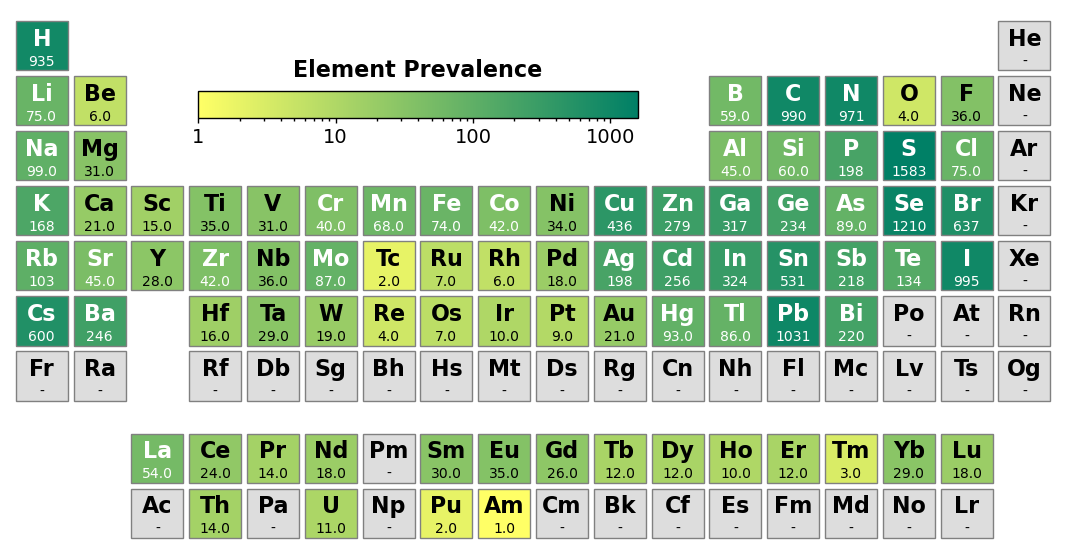

In [8]:
from pymatviz import count_elements, ptable_heatmap
import re

element_counts = count_elements([re.sub(r'\d+', '', x).replace('.', '') for x in df_grouped_formula['formula']])

# Plot the periodic table heatmap
ptable_heatmap(element_counts, log=True, cbar_title='Element Prevalence')

Let's continue and build the model in the next section!

## Build and Fit the Model 

We then fit the model using the CrabNet implementation.

/home/nomad-lanasc/anaconda3/envs/crabnet/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")



Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cpu
Model size: 11987206 parameters



Generating EDM: 100%|██████████| 2884/2884 [00:00<00:00, 136807.39formulae/s]


loading data with up to 8 elements in the formula
training with batchsize 128 (2**7.000)


Generating EDM: 100%|██████████| 360/360 [00:00<00:00, 171448.78formulae/s]

loading data with up to 8 elements in the formula
stepping every 230 training passes, cycling lr every 10 epochs
running for 300 epochs, unless early stopping occurs
checkin at 20 epochs to match lr scheduler


Epoch: 0/300 --- train mae: 0.573 val mae: 0.641


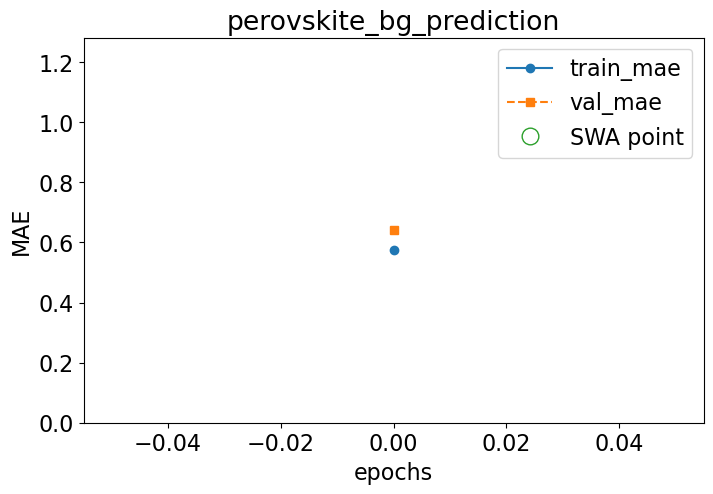

Epoch: 19/300 --- train mae: 0.268 val mae: 0.404


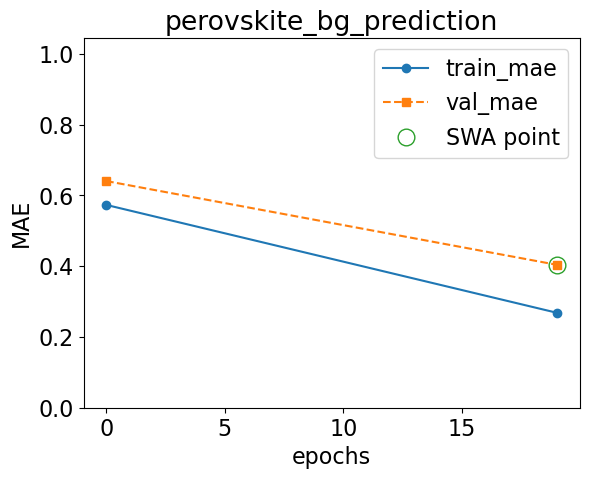

Epoch: 39/300 --- train mae: 0.173 val mae: 0.388


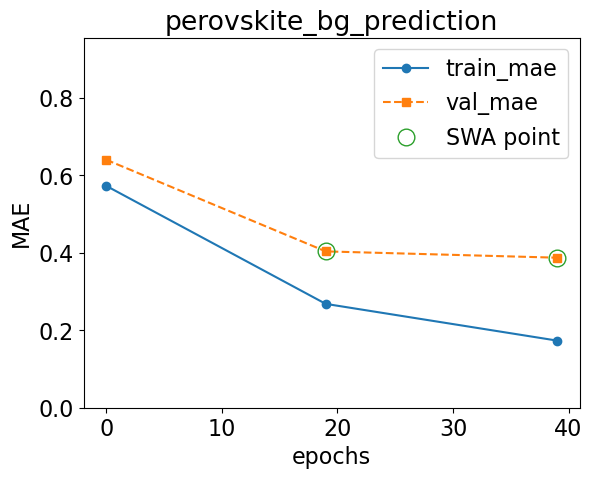

Epoch 59 failed to improve.
Discarded: 1/3 weight updates
Epoch: 59/300 --- train mae: 0.12 val mae: 0.403


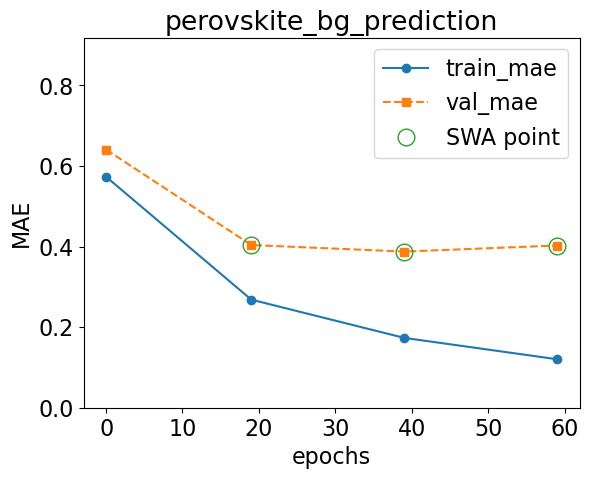

Epoch 79 failed to improve.
Discarded: 2/3 weight updates
Epoch: 79/300 --- train mae: 0.0876 val mae: 0.398


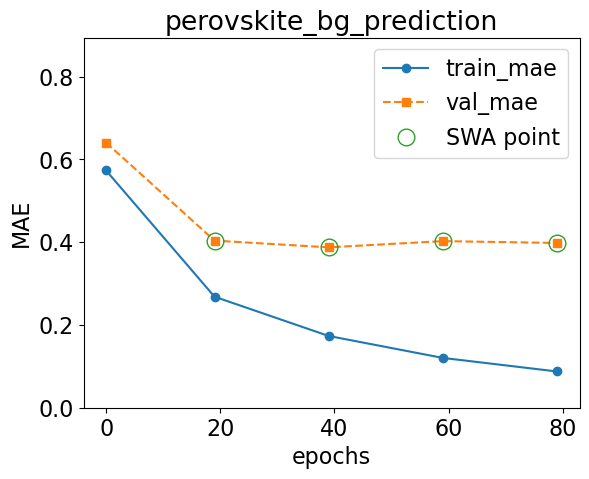

Epoch 99 failed to improve.
Discarded: 3/3 weight updates
Epoch: 99/300 --- train mae: 0.0657 val mae: 0.412


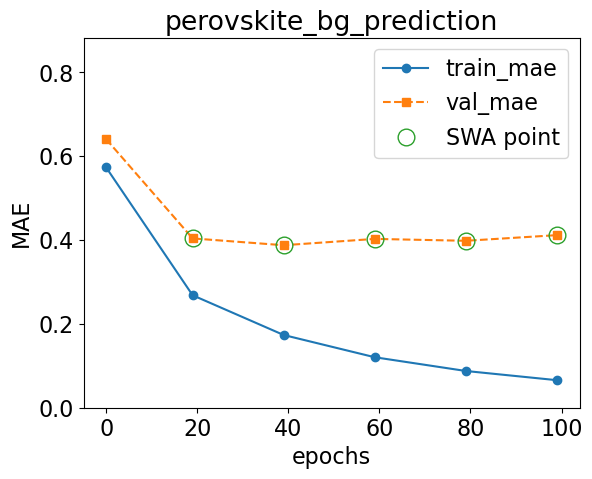

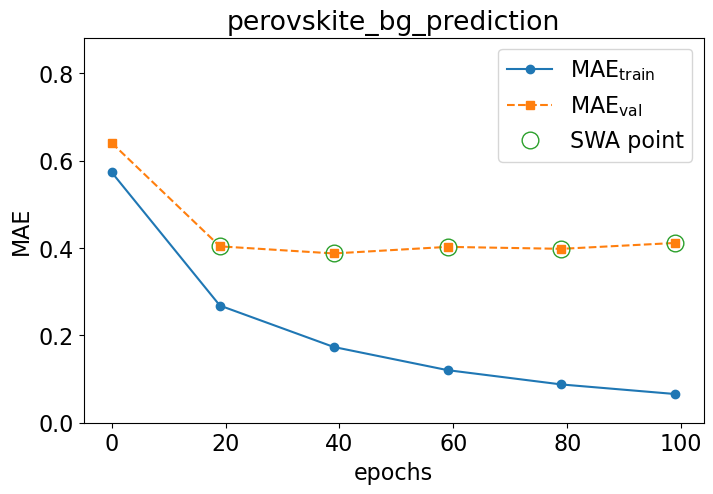

Discarded: 3/3weight updates, early-stopping now
Saving network (perovskite_bg_prediction) to models/trained_models/perovskite_bg_prediction.pth


In [17]:
from crabnet.crabnet_ import CrabNet  # type: ignore

crabnet_bandgap = CrabNet(mat_prop="bandgap", model_name='perovskite_bg_prediction', elem_prop='mat2vec', learningcurve=True,
                          extend_features=feature_names)
crabnet_bandgap.fit(train_df, val_df)

## Model evaluation

After training, we evaluate the model using the validation data.

/home/nomad-lanasc/anaconda3/envs/crabnet/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/nomad-lanasc/anaconda3/envs/crabnet/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during u


Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


Generating EDM: 100%|██████████| 2884/2884 [00:00<00:00, 139481.26formulae/s]


loading data with up to 8 elements in the formula


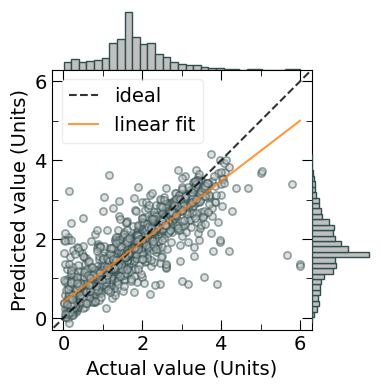

R2 score: 0.7679145713469093
MSE: 0.14103793579321883
MAE: 0.17356722813798073 eV


In [10]:
from tf_chpvk_pv.modeling.CrabNet.utils import test_r2_score

# Train data
test_r2_score(train_df, feature_names)

for validation data we have:

/home/nomad-lanasc/anaconda3/envs/crabnet/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/nomad-lanasc/anaconda3/envs/crabnet/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during u


Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


Generating EDM: 100%|██████████| 360/360 [00:00<00:00, 178249.26formulae/s]


loading data with up to 8 elements in the formula


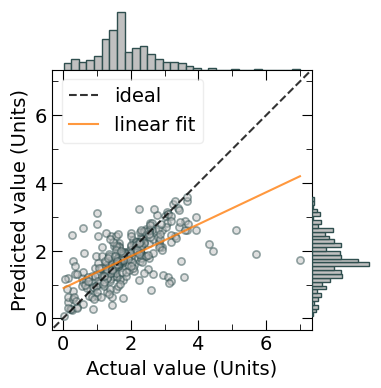

R2 score: 0.41150560126747004
MSE: 0.4669942238688566
MAE: 0.38812464347358905 eV


In [12]:
# Validation data
test_r2_score(val_df, feature_names)

and finally for test data:

/home/nomad-lanasc/anaconda3/envs/crabnet/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/nomad-lanasc/anaconda3/envs/crabnet/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during u


Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


Generating EDM: 100%|██████████| 361/361 [00:00<00:00, 153377.61formulae/s]


loading data with up to 8 elements in the formula


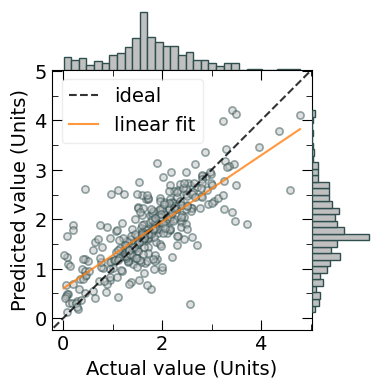

R2 score: 0.5933732603602804
MSE: 0.26864951411906873
MAE: 0.34561829300238034 eV


In [14]:
# Test data
test_r2_score(test_df, feature_names)

## Predict Bandgap from New Formulas

Now we are ready to run some predictions using our trainned model. 

In [1]:
#CrystaLLM data predictions
from tf_chpvk_pv.modeling.CrabNet.utils import get_CrystaLLM_predictions, get_SISSO_predictions, get_experimental_predictions

df_CrystaLLM = get_CrystaLLM_predictions()

#SISSO data predictions

df_SISSO = get_SISSO_predictions()

#Experimentally reported data predictions

df_experimental = get_experimental_predictions()


2025-12-05 12:57:00.816 | INFO     | tf_chpvk_pv.config:<module>:11 - PROJ_ROOT path is: /home/nomad-lanasc/Documents/Diego Garzon/TF-ChPVK-PV
/home/nomad-lanasc/anaconda3/envs/crabnet/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/nomad-lanasc/anaconda3/envs/crabnet/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details).


Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 18315.74formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 27060.03formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 18315.74formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 9000.65formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 11522.81formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 13617.87formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 13934.56formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 16320.25formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 10010.27formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 21732.15formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 18078.90formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8665.92formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 10512.04formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 9731.56formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 16844.59formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 19599.55formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 17050.02formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 16131.94formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6123.07formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 19508.39formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 18078.90formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 19972.88formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 12905.55formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 11066.77formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 20360.70formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 11459.85formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 12157.40formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 10979.85formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 11155.06formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 13273.11formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 13107.20formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 9000.65formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 9532.51formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 9058.97formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 11949.58formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 22075.28formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 20867.18formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6765.01formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 18893.26formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 10381.94formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 9446.63formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 18236.10formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 12520.31formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 14979.66formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 16513.01formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 9532.51formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 15420.24formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 19784.45formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 11008.67formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 11214.72formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 12446.01formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 11335.96formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 22919.69formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 19152.07formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 19328.59formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8905.10formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 16194.22formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 22075.28formulae/s]


loading data with up to 3 elements in the formula


/home/nomad-lanasc/anaconda3/envs/crabnet/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/nomad-lanasc/anaconda3/envs/crabnet/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during u


Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6364.65formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 18078.90formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 17189.77formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 13148.29formulae/s]

loading data with up to 3 elements in the formula



Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 15196.75formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 18893.26formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 11814.94formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 17260.51formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 16008.79formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 15592.21formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 11214.72formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 15477.14formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 9709.04formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7037.42formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 14413.42formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 16194.22formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7584.64formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 11244.78formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6853.44formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 20560.31formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 13842.59formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 16256.99formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 10305.42formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 18558.87formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 19691.57formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 10782.27formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 18315.74formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23967.45formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 21732.15formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 11305.40formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 14315.03formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 21399.51formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 19599.55formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 10782.27formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 20068.44formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23045.63formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 22075.28formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 22550.02formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 21290.88formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 18893.26formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 13842.59formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 21620.12formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24528.09formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 22310.13formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 20763.88formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 17050.02formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 17260.51formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 22795.13formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 15827.56formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 10131.17formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 9341.43formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 14027.77formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 10672.53formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 15709.00formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 11184.81formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5899.16formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 13706.88formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 16578.28formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6250.83formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7231.56formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 22192.08formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 20560.31formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 18641.35formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23431.87formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 22550.02formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 17260.51formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 16777.22formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 10058.28formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 18078.90formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 20661.60formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 21959.71formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23045.63formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 18808.54formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 19691.57formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 21076.90formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8665.92formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 13486.51formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 13888.42formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 15534.46formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8943.08formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 18978.75formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 13751.82formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 11881.88formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 10727.12formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 19239.93formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 17549.39formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 12710.01formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 13148.29formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8439.24formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 14169.95formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 12446.01formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8612.53formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6710.89formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 16710.37formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 21620.12formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 15592.21formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 10951.19formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 18641.35formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23045.63formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23967.45formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 22795.13formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 18236.10formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 12157.40formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 17476.27formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 17772.47formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 18724.57formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 10155.70formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 17549.39formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 20164.92formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8867.45formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 17119.61formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 13530.01formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 13888.42formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8774.69formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 9058.97formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 14122.24formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 17189.77formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 13315.25formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 17050.02formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 13189.64formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 11915.64formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6472.69formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 16070.13formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 15887.52formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 20661.60formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 13273.11formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 13617.87formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 14027.77formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 11275.01formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 10672.53formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 12264.05formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 15307.68formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24385.49formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 16644.06formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 16710.37formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 20560.31formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 18157.16formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23831.27formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 18477.11formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 14665.40formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23045.63formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 21290.88formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25890.77formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 22310.13formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 18558.87formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 16710.37formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24966.10formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 10034.22formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6195.43formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8322.03formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 20460.02formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 12228.29formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8943.08formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 15592.21formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 12409.18formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 11554.56formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7973.96formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23045.63formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 18558.87formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 22429.43formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 21183.35formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 19328.59formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23563.51formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25890.77formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7639.90formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 16448.25formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 16710.37formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 16008.79formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 17476.27formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 22075.28formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 15887.52formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 11037.64formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 15420.24formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 20262.34formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 20763.88formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 11275.01formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 12748.64formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 16912.52formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 14364.05formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 16578.28formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 14979.66formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 16844.59formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 14217.98formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 13706.88formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 18078.90formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 21183.35formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 17549.39formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 18558.87formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 20262.34formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 9754.20formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 13231.24formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 18893.26formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 20164.92formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 18724.57formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 15534.46formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 10922.67formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 15307.68formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 18724.57formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 18641.35formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 21959.71formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 20661.60formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25420.02formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 21959.71formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 21076.90formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 20971.52formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25266.89formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 22192.08formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 17403.75formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 22192.08formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25115.59formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 22919.69formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23831.27formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 22795.13formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 22310.13formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 17403.75formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 21290.88formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 18477.11formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23563.51formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24385.49formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24672.38formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23172.95formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 21959.71formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 22192.08formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 15827.56formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8830.11formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 9258.95formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8867.45formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 18157.16formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 14979.66formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 14074.85formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 21845.33formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24818.37formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 21732.15formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 18808.54formulae/s]

loading data with up to 3 elements in the formula



Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24672.38formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25890.77formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23967.45formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 16513.01formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24966.10formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 20661.60formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 21845.33formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 13934.56formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24818.37formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25420.02formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25115.59formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25115.59formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 22192.08formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 14665.40formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 18001.30formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 17924.38formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24966.10formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 26546.23formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 17119.61formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 26546.23formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 13189.64formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 17772.47formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6743.25formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 14665.40formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6853.44formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 18157.16formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 22192.08formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 20971.52formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 21620.12formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7503.23formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 16513.01formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 18396.07formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23172.95formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24385.49formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 19784.45formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23172.95formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23696.63formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 21959.71formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 26214.40formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 13357.66formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 20867.18formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 26051.58formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25115.59formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25731.93formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25575.02formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25266.89formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25266.89formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25420.02formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23301.69formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24244.53formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24818.37formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 17189.77formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 21183.35formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24244.53formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 26546.23formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24966.10formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25266.89formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 26546.23formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 13315.25formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 21509.25formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 21959.71formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 16578.28formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 26379.27formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23431.87formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 21620.12formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 26379.27formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23045.63formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23831.27formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 12300.01formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 27594.11formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24672.38formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25575.02formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23967.45formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24105.20formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24966.10formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25266.89formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 22795.13formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23431.87formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25575.02formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25575.02formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 21845.33formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 27235.74formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24528.09formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 17772.47formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25890.77formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 13025.79formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 11491.24formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 12520.31formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 17697.49formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 14413.42formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 16777.22formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 11748.75formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 28339.89formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 21620.12formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23696.63formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 20360.70formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24244.53formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 16710.37formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23563.51formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 26379.27formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 22192.08formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24244.53formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25731.93formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 20164.92formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 21845.33formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23831.27formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 12228.29formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 19691.57formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 16448.25formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 12228.29formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24528.09formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 27235.74formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25420.02formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 22919.69formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23967.45formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 20661.60formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 10459.61formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23301.69formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 22671.91formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 12052.60formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 10330.80formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 20460.02formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 16777.22formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25890.77formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 21959.71formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23967.45formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 20164.92formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 15534.46formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 17924.38formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 20867.18formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 19065.02formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25575.02formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 26051.58formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25890.77formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23172.95formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 26051.58formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 9709.04formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 20560.31formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 22671.91formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 19152.07formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 13486.51formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23431.87formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24966.10formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 12748.64formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23967.45formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23563.51formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 20867.18formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24966.10formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 21959.71formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23967.45formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25575.02formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24672.38formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 14926.35formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 21076.90formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 18893.26formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 17772.47formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 20460.02formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 13797.05formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 20560.31formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8272.79formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8050.49formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 10082.46formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 11459.85formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 19599.55formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 14614.30formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 22919.69formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23831.27formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24672.38formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24966.10formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 19239.93formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 22550.02formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 22192.08formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 20661.60formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 12122.27formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23431.87formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 22075.28formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23172.95formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25890.77formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 22192.08formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24385.49formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25731.93formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24672.38formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24385.49formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 22919.69formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25115.59formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23831.27formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23431.87formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24672.38formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 14169.95formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23045.63formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 18157.16formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 16513.01formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 15252.01formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 20460.02formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 17331.83formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24818.37formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 17189.77formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 15252.01formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24818.37formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23045.63formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 19152.07formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25266.89formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 22310.13formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23045.63formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 17697.49formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 20068.44formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 22795.13formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25890.77formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24385.49formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 22075.28formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 13981.01formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25731.93formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 22310.13formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 21399.51formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 14873.42formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 22671.91formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 21620.12formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 22550.02formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 22192.08formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23045.63formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24818.37formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24528.09formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23045.63formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 21959.71formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23172.95formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23045.63formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23967.45formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 19152.07formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 21399.51formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 22795.13formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 15363.75formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8192.00formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8756.38formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 20460.02formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 18396.07formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 17189.77formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 22919.69formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 21620.12formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25266.89formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24672.38formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 21732.15formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 19972.88formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25266.89formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 20661.60formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 13934.56formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 20661.60formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 22671.91formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 26379.27formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 22075.28formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24105.20formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 18078.90formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 13617.87formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 18724.57formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 21290.88formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 15033.35formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 13357.66formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24528.09formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 18808.54formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 18641.35formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23431.87formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 26051.58formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25266.89formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25266.89formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25266.89formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23301.69formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 14413.42formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 12087.33formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 14463.12formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23172.95formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23431.87formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23831.27formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25266.89formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25115.59formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 21509.25formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25266.89formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25420.02formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 21290.88formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24244.53formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24818.37formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 22919.69formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24244.53formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 16710.37formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 21290.88formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 19508.39formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 19328.59formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25890.77formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 27235.74formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 16008.79formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24385.49formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 12748.64formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 21845.33formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23172.95formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24528.09formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24818.37formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 18893.26formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 19784.45formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24385.49formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23301.69formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25731.93formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25420.02formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 26051.58formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 14926.35formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 19508.39formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 9000.65formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 22192.08formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 22795.13formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7108.99formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 22310.13formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 21509.25formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 20661.60formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 21959.71formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 15363.75formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 26214.40formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23563.51formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 21732.15formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24385.49formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 20164.92formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23696.63formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23172.95formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25266.89formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 21620.12formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 16008.79formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24528.09formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 17697.49formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 22429.43formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 18157.16formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23831.27formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 19328.59formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 19878.22formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24528.09formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24385.49formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23696.63formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25575.02formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23563.51formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 19328.59formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 21959.71formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 11428.62formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 15420.24formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 18477.11formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 18558.87formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8924.05formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 19065.02formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 22919.69formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24244.53formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 12228.29formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 22310.13formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 22429.43formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 21620.12formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23431.87formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24818.37formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 21845.33formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 22550.02formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23831.27formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23431.87formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 22671.91formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 13025.79formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 22429.43formulae/s]

loading data with up to 3 elements in the formula



Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 17623.13formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23696.63formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25575.02formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 20560.31formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 22671.91formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 20460.02formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 16384.00formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 22550.02formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23301.69formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 18001.30formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 19878.22formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24818.37formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25575.02formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 21509.25formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 19599.55formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 17772.47formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 21183.35formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 19508.39formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24244.53formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24244.53formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 21732.15formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 20971.52formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 18808.54formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 19152.07formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23045.63formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 26051.58formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24966.10formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23301.69formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 21290.88formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23301.69formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 14614.30formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24244.53formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23301.69formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25420.02formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 19508.39formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 19418.07formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23172.95formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 16070.13formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 13797.05formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 15947.92formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 16980.99formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23045.63formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 9754.20formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 18893.26formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 22075.28formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23563.51formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 26546.23formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 26051.58formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 21076.90formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 19878.22formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 21183.35formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 14979.66formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 12985.46formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24528.09formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 27060.03formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25731.93formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 26051.58formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 17403.75formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 20460.02formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 26715.31formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24672.38formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 27413.75formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24528.09formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23696.63formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24244.53formulae/s]

loading data with up to 3 elements in the formula



Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25575.02formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 26051.58formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 27594.11formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 26379.27formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 16644.06formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 18978.75formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 21732.15formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 20763.88formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 21290.88formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25115.59formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 20971.52formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24528.09formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24966.10formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 21732.15formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 21399.51formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23431.87formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 20262.34formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 26051.58formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 20763.88formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23563.51formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 10058.28formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8683.86formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 16912.52formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23172.95formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 20560.31formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 10866.07formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 18157.16formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 22550.02formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25420.02formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 9279.43formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 26715.31formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 12052.60formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 19599.55formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 26051.58formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 22795.13formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 22310.13formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24672.38formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 22671.91formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 18315.74formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 21076.90formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23831.27formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23563.51formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 15033.35formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 14513.16formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 20560.31formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23301.69formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25420.02formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24528.09formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24528.09formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25420.02formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23831.27formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 18236.10formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 12945.38formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25575.02formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 27235.74formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24966.10formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6898.53formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 14563.56formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6842.26formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 9776.93formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 12985.46formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 21732.15formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 21076.90formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 19239.93formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24818.37formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 20971.52formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 12520.31formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23301.69formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 27060.03formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 18978.75formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 16710.37formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 26379.27formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 27776.85formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 26546.23formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 18724.57formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23696.63formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 26886.56formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23431.87formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 21959.71formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 17924.38formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23301.69formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23563.51formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 21183.35formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 16070.13formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 20360.70formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 21183.35formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24244.53formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24966.10formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25731.93formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25575.02formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23696.63formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 18893.26formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 26051.58formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23431.87formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 11586.48formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 21959.71formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 20971.52formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 19784.45formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 19239.93formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24672.38formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 21183.35formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23045.63formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23696.63formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 22429.43formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23301.69formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 18236.10formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25115.59formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 26379.27formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23831.27formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25731.93formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 18808.54formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 19508.39formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 20360.70formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 15363.75formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 18808.54formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 22919.69formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23831.27formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 21509.25formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23831.27formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24818.37formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 12122.27formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 11848.32formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23563.51formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 22429.43formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 22192.08formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 18236.10formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25890.77formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24105.20formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 12264.05formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 13400.33formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 17924.38formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 14413.42formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7530.17formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 21183.35formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 14027.77formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 20460.02formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25115.59formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25420.02formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25731.93formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25731.93formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24966.10formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 26379.27formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 18978.75formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 16131.94formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 19239.93formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 20661.60formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24966.10formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23045.63formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 17476.27formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23967.45formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25266.89formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24105.20formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 17476.27formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 17623.13formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 17848.10formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 22310.13formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 18396.07formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 13025.79formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24528.09formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 19599.55formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 12336.19formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 9198.04formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7781.64formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 17549.39formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 11125.47formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 19691.57formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 22429.43formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 21620.12formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 22192.08formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 13934.56formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 15087.42formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 22550.02formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24966.10formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25890.77formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24818.37formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 20164.92formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 21845.33formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24385.49formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25266.89formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 20164.92formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 26214.40formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23696.63formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 19878.22formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 15307.68formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 22075.28formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23172.95formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 20460.02formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 22671.91formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25266.89formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 21290.88formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 15709.00formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23967.45formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23563.51formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 20460.02formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24244.53formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24244.53formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 21959.71formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25890.77formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 22075.28formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 20068.44formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24385.49formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 20164.92formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 12710.01formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23301.69formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23967.45formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25420.02formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25420.02formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24105.20formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 22550.02formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 26546.23formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 15887.52formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 19152.07formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24672.38formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24818.37formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 21290.88formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23831.27formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24105.20formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23696.63formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 19972.88formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24966.10formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23045.63formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24966.10formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 22550.02formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 22671.91formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23696.63formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25266.89formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24818.37formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 12157.40formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 18724.57formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8594.89formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8112.77formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 17476.27formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 9686.61formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23431.87formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 20560.31formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 20971.52formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25731.93formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 22310.13formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25731.93formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 26715.31formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 18396.07formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24818.37formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25266.89formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 17623.13formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 21076.90formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 21076.90formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 16131.94formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 26051.58formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 27235.74formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 28339.89formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 21509.25formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 21620.12formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 12446.01formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 18396.07formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 26051.58formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25731.93formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 22075.28formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23696.63formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24672.38formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 18724.57formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25890.77formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 18558.87formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 17403.75formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 12018.06formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 9300.01formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5349.88formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23301.69formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 13573.80formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23563.51formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 19599.55formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 13066.37formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 22310.13formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 22310.13formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23172.95formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 22429.43formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 19418.07formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 19152.07formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 19784.45formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 22310.13formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25575.02formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24385.49formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24528.09formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25575.02formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24528.09formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23301.69formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 15033.35formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23172.95formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 22075.28formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23696.63formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 21845.33formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 22919.69formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24528.09formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23831.27formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 20164.92formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24244.53formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 21509.25formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 21620.12formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24385.49formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 19065.02formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 18978.75formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23563.51formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 18001.30formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 17924.38formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 19972.88formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25266.89formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25731.93formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23301.69formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 22919.69formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 21845.33formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 19239.93formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 15947.92formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23696.63formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 22919.69formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24385.49formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 21076.90formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23301.69formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 18978.75formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 16513.01formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 18396.07formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25115.59formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23301.69formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 22310.13formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 27235.74formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24385.49formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 14665.40formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8962.19formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 22671.91formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 19239.93formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25115.59formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 20867.18formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 14364.05formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 26051.58formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 22919.69formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 21620.12formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25731.93formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 22795.13formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 16513.01formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 21959.71formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 18978.75formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24528.09formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 22429.43formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 20661.60formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24244.53formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 15477.14formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 26379.27formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 22075.28formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 17848.10formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24672.38formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25575.02formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 21732.15formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25731.93formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 11650.84formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25575.02formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24105.20formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 20068.44formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25731.93formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 22550.02formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25890.77formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24966.10formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23696.63formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 27962.03formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 26546.23formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23967.45formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 17697.49formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 21959.71formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23301.69formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 21076.90formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 26379.27formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24385.49formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 19599.55formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23301.69formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23301.69formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 26715.31formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25420.02formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25890.77formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23967.45formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 13443.28formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7825.19formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 22310.13formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7667.83formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8867.45formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23172.95formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 10699.76formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 22075.28formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 14768.68formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 26214.40formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23831.27formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24966.10formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24818.37formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23301.69formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 27235.74formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23831.27formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 15252.01formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 19065.02formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24528.09formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 13842.59formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 28926.23formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25266.89formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 27235.74formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 27235.74formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 27060.03formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25575.02formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23172.95formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23831.27formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 26214.40formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 21183.35formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 27776.85formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 27594.11formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25575.02formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 19328.59formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 21732.15formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24818.37formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 22192.08formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25575.02formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24244.53formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 21732.15formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23967.45formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25115.59formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 26214.40formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 21620.12formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 23301.69formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25731.93formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 22429.43formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 19972.88formulae/s]


loading data with up to 3 elements in the formula


/home/nomad-lanasc/anaconda3/envs/crabnet/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/nomad-lanasc/anaconda3/envs/crabnet/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during u


Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


/home/nomad-lanasc/anaconda3/envs/crabnet/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/nomad-lanasc/anaconda3/envs/crabnet/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during u


Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24966.10formulae/s]


loading data with up to 3 elements in the formula
Experimental bandgap for BaZrS3: 1.75 eV
Bandgap prediction for BaZrS3: 1.68 ± 0.14 eV


/home/nomad-lanasc/anaconda3/envs/crabnet/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")



Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


/home/nomad-lanasc/anaconda3/envs/crabnet/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  network = torch.load(path, map_

loading data with up to 3 elements in the formula
Experimental bandgap for BaTiS3: 1.3 eV
Bandgap prediction for BaTiS3: 1.31 ± 1.91 eV

Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 9664.29formulae/s]

loading data with up to 3 elements in the formula
Experimental bandgap for LaYS3: 2.3 eV
Bandgap prediction for LaYS3: 1.88 ± 0.11 eV



/home/nomad-lanasc/anaconda3/envs/crabnet/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/nomad-lanasc/anaconda3/envs/crabnet/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during 


Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 10230.01formulae/s]


loading data with up to 3 elements in the formula
Experimental bandgap for CaZrS3: 1.5 eV
Bandgap prediction for CaZrS3: 1.52 ± 0.12 eV


/home/nomad-lanasc/anaconda3/envs/crabnet/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/nomad-lanasc/anaconda3/envs/crabnet/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during u


Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 25115.59formulae/s]


loading data with up to 3 elements in the formula
Experimental bandgap for BaZrSe3: 1.3 eV
Bandgap prediction for BaZrSe3: 1.39 ± 0.11 eV


/home/nomad-lanasc/anaconda3/envs/crabnet/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/nomad-lanasc/anaconda3/envs/crabnet/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during u


Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 24966.10formulae/s]

loading data with up to 3 elements in the formula
Experimental bandgap for BaHfS3: 2.17 eV
Bandgap prediction for BaHfS3: 1.97 ± 0.25 eV



/home/nomad-lanasc/anaconda3/envs/crabnet/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/nomad-lanasc/anaconda3/envs/crabnet/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during 


Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 14315.03formulae/s]


loading data with up to 3 elements in the formula
Experimental bandgap for SrZrS3: 2.05 eV
Bandgap prediction for SrZrS3: 1.58 ± 0.13 eV


/home/nomad-lanasc/anaconda3/envs/crabnet/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/nomad-lanasc/anaconda3/envs/crabnet/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during u


Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8811.56formulae/s]


loading data with up to 3 elements in the formula
Experimental bandgap for SrHfS3: 2.32 eV
Bandgap prediction for SrHfS3: 1.86 ± 0.3 eV

Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


/home/nomad-lanasc/anaconda3/envs/crabnet/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/nomad-lanasc/anaconda3/envs/crabnet/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during u

loading data with up to 4 elements in the formula
Experimental bandgap for BaZr(S0.6Se0.4)3: 1.76 eV
Bandgap prediction for BaZr(S0.6Se0.4)3: 1.67 ± 0.15 eV


/home/nomad-lanasc/anaconda3/envs/crabnet/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/nomad-lanasc/anaconda3/envs/crabnet/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during u


Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 10106.76formulae/s]
/home/nomad-lanasc/anaconda3/envs/crabnet/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


loading data with up to 4 elements in the formula
Experimental bandgap for Ba(Zr0.95Ti0.05)S3: 1.63 eV
Bandgap prediction for Ba(Zr0.95Ti0.05)S3: 1.59 ± 0.08 eV


/home/nomad-lanasc/anaconda3/envs/crabnet/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  network = torch.load(path, map_


Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 21399.51formulae/s]

loading data with up to 4 elements in the formula
Experimental bandgap for Ba(Zr0.96Ti0.04)S3: 1.51 eV
Bandgap prediction for Ba(Zr0.96Ti0.04)S3: 1.54 ± 0.04 eV
